<a href="https://colab.research.google.com/github/Apekshagaonkar/dl_covid/blob/main/0.Dataset_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [11]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [12]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/BEASF.py" .

In [13]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/visualization_tools.py" .

In [14]:
!pip3 install lime

In [15]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

import matplotlib.pyplot as plt


# read Data and convert to npy

In [16]:
def get_images(img_path): # FUNCTION FOR 1 FOLDER WITH ALL IMAGES MIXED WITH RESPECTIVE LABEL NAME
  normal_images = list()
  cap_images = list()
  covid_images = list()
  for img_name in glob.glob(pathname=img_path + '/*'):
    img = load_img(path=img_name, color_mode='grayscale')
    img = img_to_array(img=img, data_format='channels_last')
    if 'COVID' in img_name:
      covid_images.append(img)
    elif 'pneumonia' in img_name:
      cap_images.append(img)
    elif 'normal' in img_name:
      normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  covid_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  covid_labels = [2 for _ in range(len(covid_images))]

  X = np.concatenate((covid_images, cap_images, normal_images))
  y = np.array(covid_labels + cap_labels + normal_labels)
  return X,y

def get_images(img_path): # FUNCTION FOR 1 FOLDER WITH FOLDERS WITH LABEL NAME AND RESPECTIVE IMAGES
  normal_images = list()
  cap_images = list()
  covid_images = list()
  print(glob.glob(pathname=img_path + '/*'))
  for folder_name in glob.glob(pathname=img_path + '/*'):
    print(folder_name)
    img_path =folder_name
    if 'covid' in folder_name:
      for img_name in glob.glob(pathname=img_path + '/*'):
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        covid_images.append(img)
    elif 'PNEUMONIA' in folder_name:
       for img_name in glob.glob(pathname=img_path + '/*'):
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        cap_images.append(img)
    elif 'NORMAL' in folder_name:
       for img_name in glob.glob(pathname=img_path + '/*'):
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  covid_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  covid_labels = [2 for _ in range(len(covid_images))]

  X = np.concatenate((covid_images, cap_images, normal_images))
  y = np.array(covid_labels + cap_labels + normal_labels)
  return X,y


In [17]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n) : default = n need to remove commented code if needed to export")
    """if input() == 'y':
        np.save('./covid_cxr_dataset/cxr_samples.npy', arr=data)
        np.save('./covid_cxr_dataset/cxr_labels.npy', arr=labels)
    else:
        print('dataset exportation aborted.')"""
    print('saved as ./covid_cxr_dataset/cxr_samples.npy')
    print('saved as ./covid_cxr_dataset/cxr_labels.npy')

In [18]:
!ls

 0.Dataset_prep.ipynb	      Model_flow.ipynb
 1.Image_segmentation.ipynb   Pretrained_Model
 2.Training_model.ipynb      'Projects progress.gdoc'
 Additional		      __pycache__
 BEASF.py		      References
 covid_cxr_dataset	      tmp.h5
 Documents		     'v1.0_eps=099_valAcc=0.9672.hdf5'
 Jupyter_notebooks	      visualization_tools.py


In [19]:
data_path = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data'

#X,y = get_images(img_path=data_path)


In [20]:
p2c = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19'
p2p = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA'
p2n = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL'

In [21]:
i=0
covid_images = list()
for img_name in glob.glob(pathname=p2c + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        covid_images.append(img)
        i = i+1
        if i == 100: 
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/024.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/030.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/029.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/061.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/080.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/033.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/010.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/014.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/025.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/006.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/042.png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/covid19/062.jpeg
/content/d

In [22]:
len(covid_images)

100

In [23]:
i=0
cap_images = list()
for img_name in glob.glob(pathname=p2p + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        cap_images.append(img)
        i = i+1
        if i==100:
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person103_bacteria_489.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person100_bacteria_477.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person100_bacteria_482.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person108_bacteria_506.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person100_bacteria_479.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person101_bacteria_485.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person104_bacteria_491.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person100_bacteria_478.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/person100_bacteria_481.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_dat

In [24]:
len(cap_images)

100

In [25]:
i=0
normal_images = list()
for img_name in glob.glob(pathname=p2n + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        normal_images.append(img)
        i = i + 1
        if i == 100:
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0519-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0520-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0521-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0531-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0530-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0533-0001-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0532-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0525-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0528-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0534-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0526-0001

In [31]:
normal_images = np.array(normal_images)
cap_images    = np.array(cap_images)
covid_images  = np.array(covid_images)

normal_labels = [0 for _ in range(len(normal_images))]
cap_labels    = [1 for _ in range(len(cap_images))]
covid_labels  = [2 for _ in range(len(covid_images))]

X = np.concatenate((covid_images, cap_images, normal_images))
y = np.array(covid_labels + cap_labels + normal_labels)

print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [27]:
np.save('/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_samples.npy', arr=X)
np.save('/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_labels.npy', arr=y)

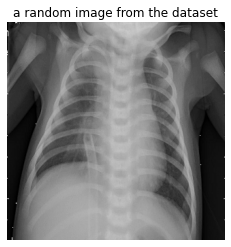

number of total dataset images: 300
number of total dataset labels: 300
dataset shape: (300, 320, 320, 1)
export images as npy file? (y/n) : default = n need to remove commented code if needed to export
saved as ./covid_cxr_dataset/cxr_samples.npy
saved as ./covid_cxr_dataset/cxr_labels.npy


In [28]:
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

# Verifying the dataset preperation

number of total dataset images: 300
number of total dataset labels: 300
dataset shape: (300,)


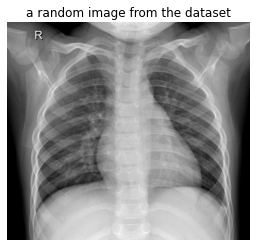

In [29]:

X = np.load('/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_samples.npy', allow_pickle=True)
y = np.load('/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_labels.npy', allow_pickle=True)

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [30]:
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
